In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from xgboost import XGBClassifier

test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
submission_sample = pd.read_csv('sample_submission.csv')

# _House Sales Price Prediction Project_

## _Prompt_
> ##### Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence. With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

> #####  1.  Data has already been separated into training and testing dataframes.
> #####  2.  Data dictionary within the repo describes each feature. 
> #####  3.  Data was pulled from Kaggle(https://www.kaggle.com/c/house-prices-advanced-regression-techniques). 

## _Initial EDA_

In [2]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#Even split between the two
print('test shape ', test.shape)
print('train shape ', train.shape)

test shape  (1459, 80)
train shape  (1460, 81)


In [4]:
#Taking a look at our features and object type for each column
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

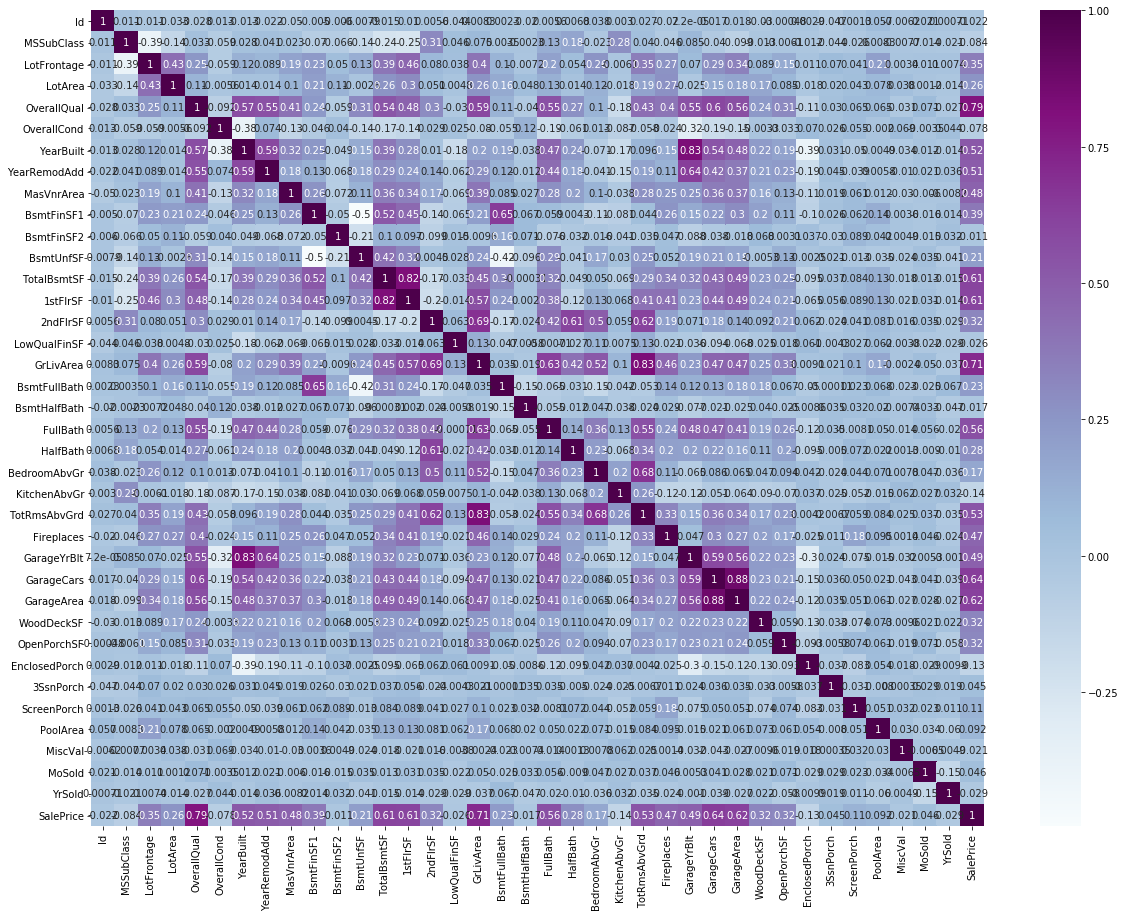

In [5]:
#Heatmap to explore key relationships visually
train_heat = train.corr()
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(train_heat, vmax=1.0, annot=True, cmap='BuPu');

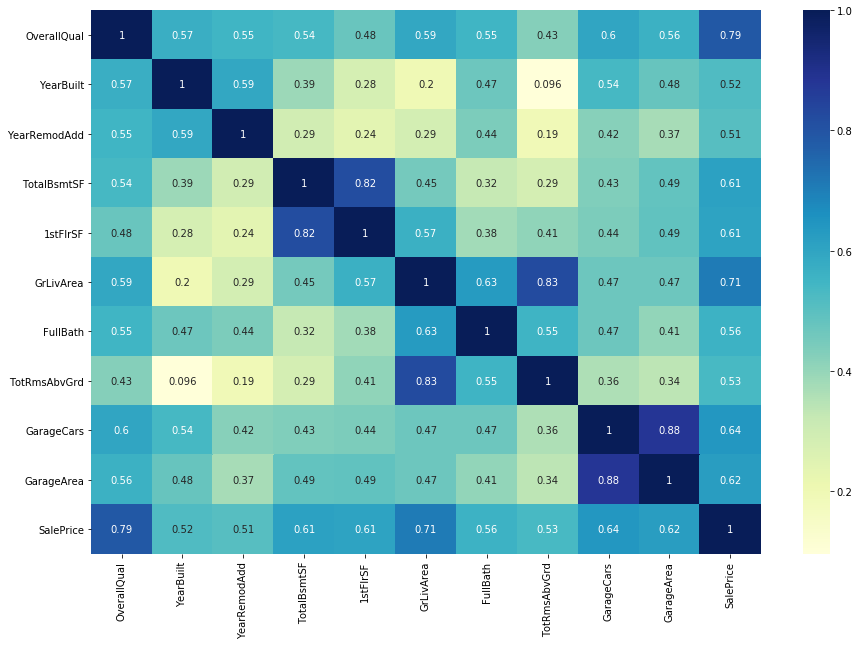

In [6]:
#Refinind the above to only include feteares with a high level of correlation
corrmat = train.corr()
top_correlation_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(15,10))
g = sns.heatmap(train[top_correlation_features].corr(),annot=True,cmap="YlGnBu")

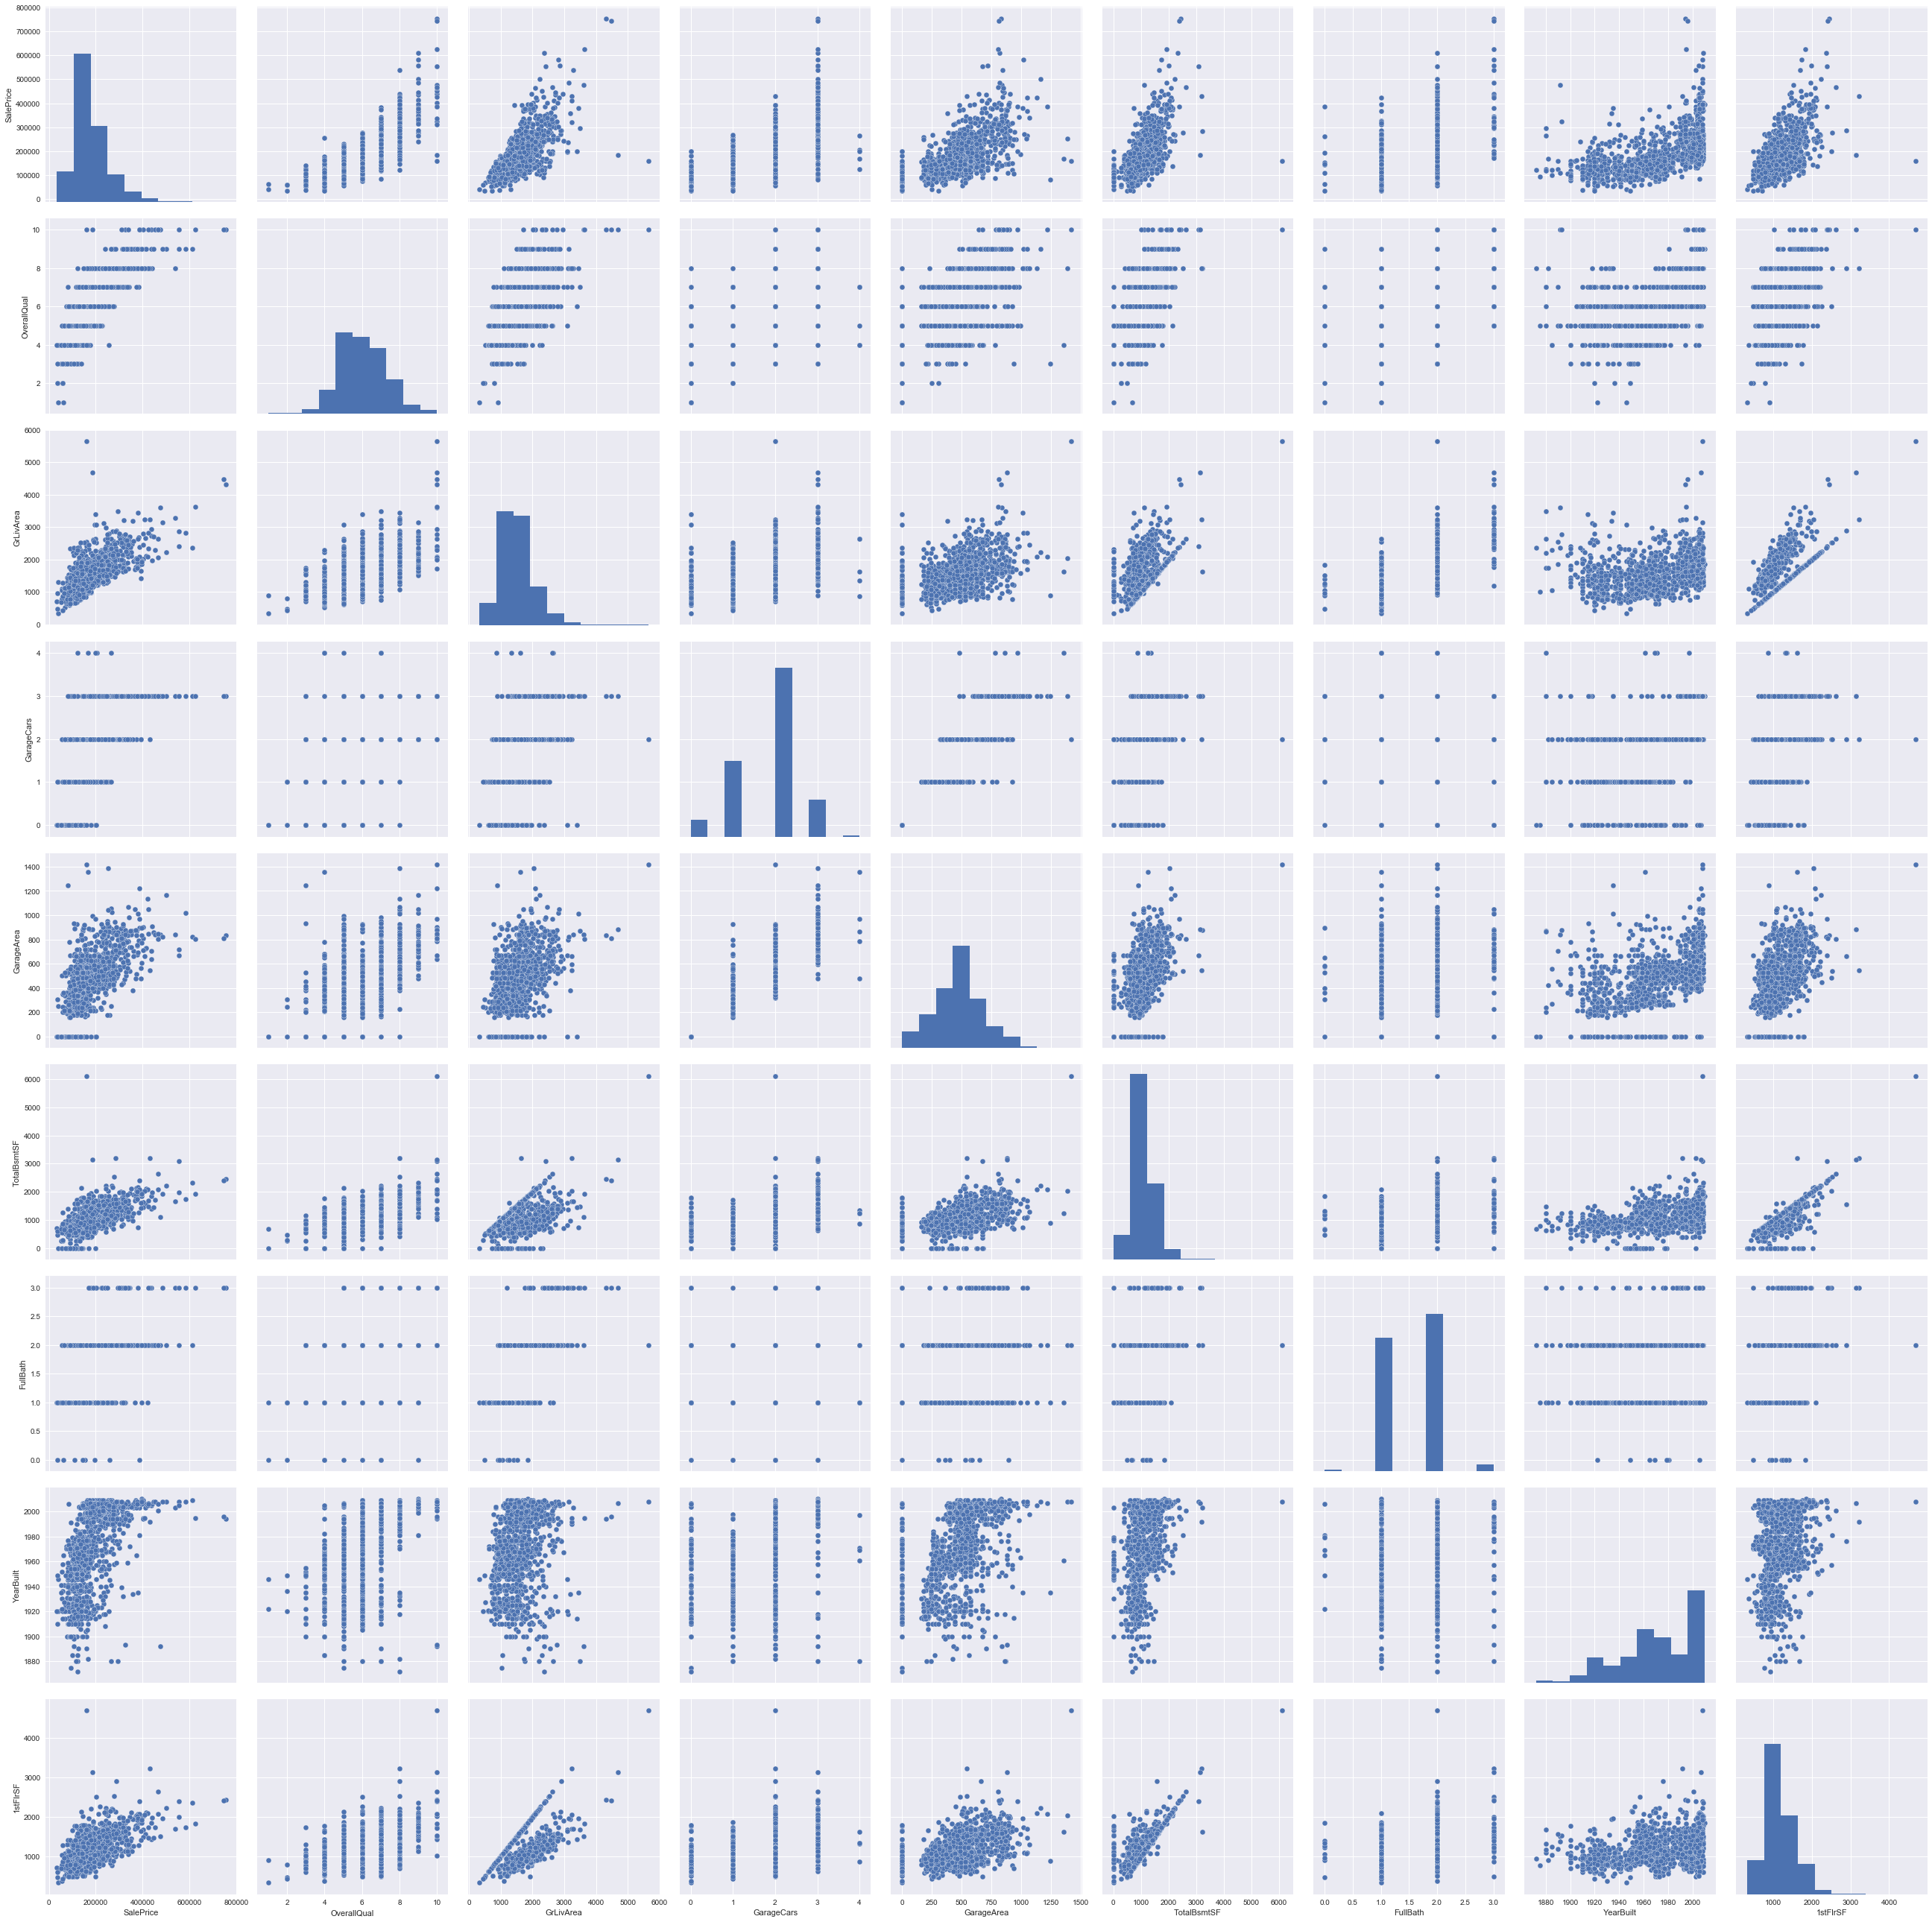

In [7]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt', '1stFlrSF']
sns.pairplot(train[cols], size = 4.0)
plt.show();

In [8]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002F815912C18>,
      dtype=object)

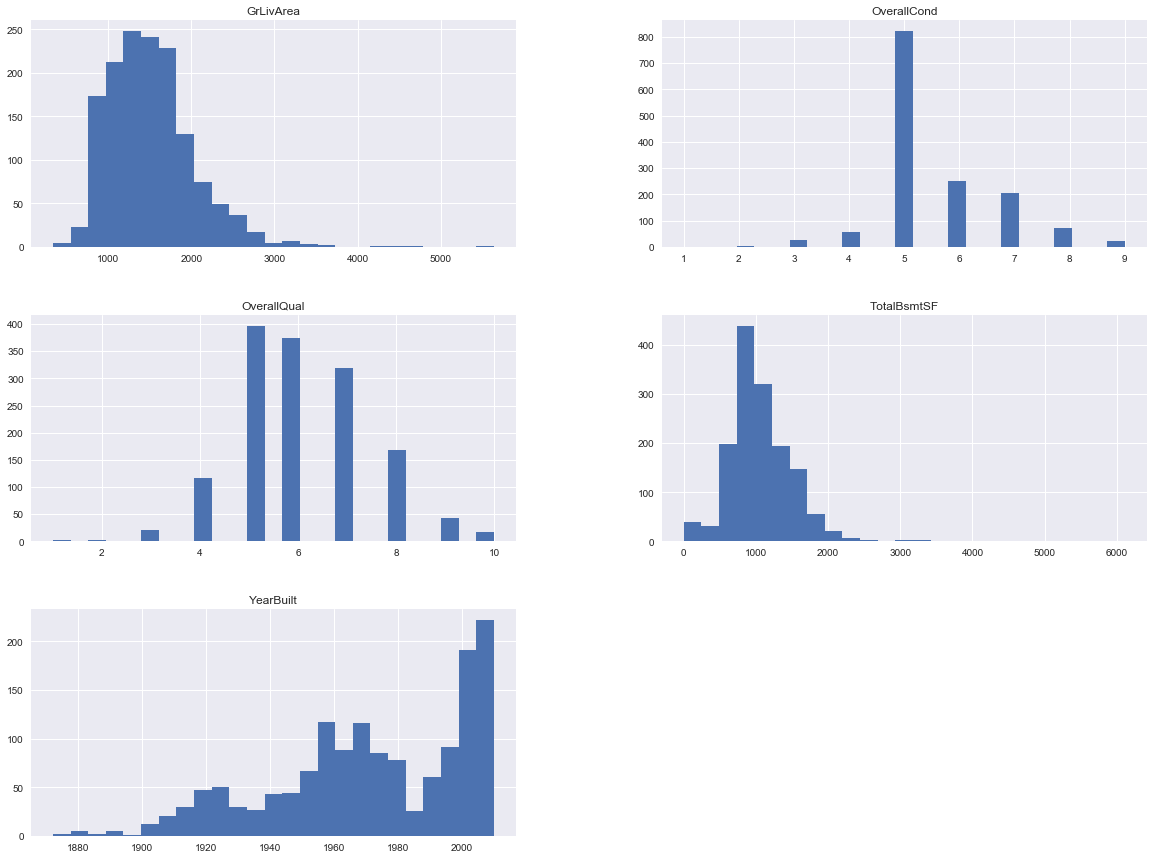

In [9]:
#Selected feature distrubtion
fields = ['OverallQual', 'OverallCond', 'YearBuilt',
             'GrLivArea', 'TotalBsmtSF']
train[fields].hist(bins=25, figsize=(20,15))

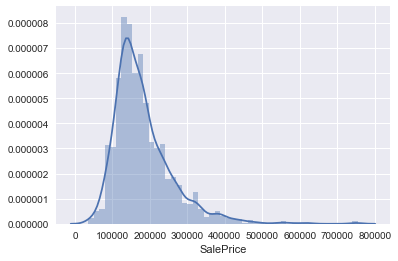

In [10]:
#Price distribution
sns.distplot(train['SalePrice'])

In [11]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [12]:
#Taking a closer look at a subset of categorical and numerical features
def plot_scatter(var):
    data = pd.concat([train['SalePrice'], train[var]], axis=1)
    data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [13]:
selection = ['OverallQual', 'OverallCond', 'YearBuilt',
             'GrLivArea', 'TotalBsmtSF']

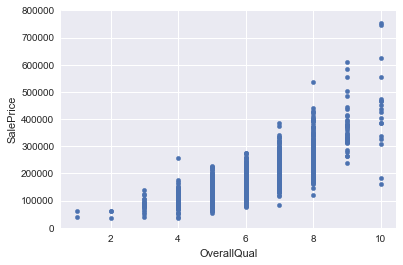

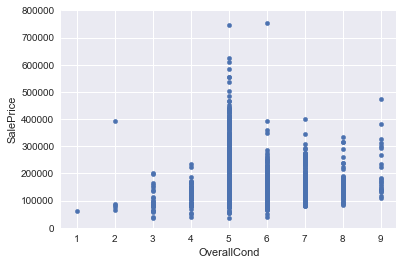

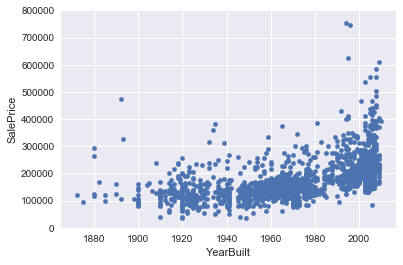

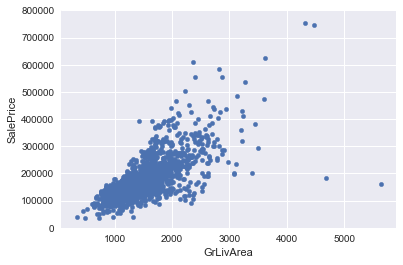

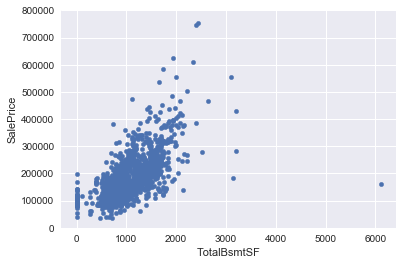

In [14]:
for var in selection:
    plot_scatter(var)

In [15]:
def plot_cat(var):
    data = pd.concat([train['SalePrice'], train[var]], axis=1)
    f, ax = plt.subplots(figsize=(8, 6))
    fig = sns.boxplot(x=var, y="SalePrice", data=data)
    fig.axis(ymin=0, ymax=800000);

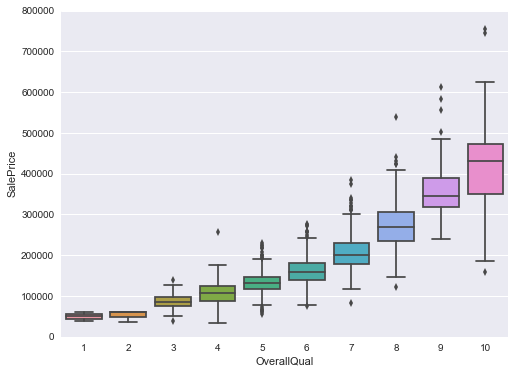

In [16]:
#Makes sense.....
plot_cat('OverallQual')

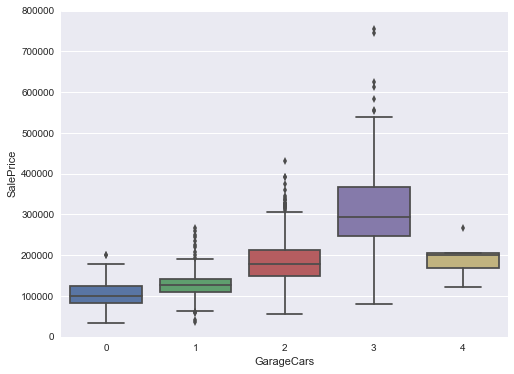

In [17]:
#3 car garages seem to have a more significant pull on price
plot_cat('GarageCars')

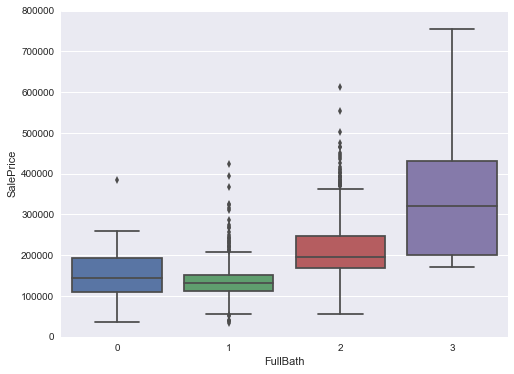

In [18]:
plot_cat('FullBath')

## _Preprocessing_

In [19]:
#How much missng data are we dealing with in the training df?
#Missing data within the train set. Will probably end up dropping the top 6 missing. 
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
total = train.isnull().sum().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(79)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [20]:
train_pre = train.copy()

In [21]:
#Dropping columns with large percentages of missing data
train_pre.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

(array([ 73., 132., 295., 348., 219.,  79.,  29.,  11.,   7.,   2.,   3.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([ 21. ,  35.6,  50.2,  64.8,  79.4,  94. , 108.6, 123.2, 137.8,
        152.4, 167. , 181.6, 196.2, 210.8, 225.4, 240. , 254.6, 269.2,
        283.8, 298.4, 313. ]),
 <a list of 20 Patch objects>)

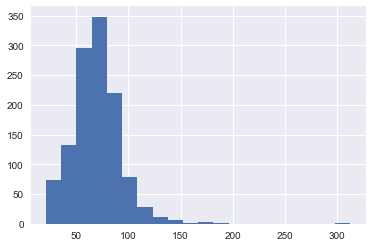

In [22]:
#Imputing 'LotFrontage' with the median value
plt.hist(train_pre["LotFrontage"][train_pre["LotFrontage"].notnull()], bins = 20)

In [23]:
#Manual way of imputing, using a specific imputer, and creating a pipeline to impute

#(1)

train_pre["LotFrontage"].fillna(train_pre["LotFrontage"].median(), inplace = True)

#(2)

# # isolate fields we want to impute within
# field = ['LotFrontage']
# train_lot = train['lotFrontage']

# # create imputer
# imputer = Imputer(strategy='median')

# # calculate medians for each field
# imputer.fit(train_lot)  # imputer.statistics_ contains vector of medians

# # fill in missing values with medians
# train_lot_imputed = imputer.transform(train_lot)

# # stick back into DataFrame
# train_lot_imputed = pd.DataFrame(
#     train_lot_imputed, 
#     columns=train_lot.columns,
# )

#(3)

#Create a pipleine to do all the precprocessing which I will do later to pass the test data to for final submission. 

In [24]:
train_pre.LotFrontage.isnull().sum()

0

In [25]:
#Dealing with the rest of the null values
na_cols_train = ['GarageCond', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 
                 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 
                 'MasVnrArea', 'MasVnrType', 'Electrical']

In [26]:
#Seeing if mode will be the best approach to impute for the rest
train_missing = train_pre[na_cols_train]
train_missing.mode()

,GarageCond,GarageType,GarageYrBlt,GarageFinish,GarageQual,BsmtExposure,BsmtFinType2,BsmtFinType1,BsmtCond,BsmtQual,MasVnrArea,MasVnrType,Electrical
0,TA,Attchd,2005.0,Unf,TA,No,Unf,Unf,TA,TA,0.0,None,SBrkr


In [27]:
#Using another method
train_pre[na_cols_train] = train_pre[na_cols_train].fillna(train_pre.mode().iloc[0])

In [28]:
#Chekcing to see if we're missing any more values
train_pre.isnull().sum().value_counts()

0    76
dtype: int64

## _Random Forest Regression_

In [29]:
#Key columns to try
predictor_cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']

In [30]:
y = train_pre.SalePrice
X = train_pre[predictor_cols]

In [31]:
X.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
0,7,1710,2,548,856,856,2,8,2003,2003
1,6,1262,2,460,1262,1262,2,6,1976,1976
2,7,1786,2,608,920,920,2,6,2001,2002
3,7,1717,3,642,756,961,1,7,1915,1970
4,8,2198,3,836,1145,1145,2,9,2000,2000


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [33]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
predicted_price = rf_model.predict(X_test)

In [34]:
#An initial ~83-85% degree of accuracy at predicting the price of the house within the train dataset.
explained_variance_score(y_test, predicted_price)

0.8347973980154142

In [35]:
#Using the the mean absolute error (MAE) as a metric to validate model results
mean_absolute_error(y_test, predicted_price)

19881.22694063927

In [36]:
#Preprocessing test data
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
total = train.isnull().sum().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(79)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [37]:
na_cols_test = ['GarageYrBlt', 'GarageFinish', 'GarageCond', 'GarageQual', 'GarageType', 'BsmtCond', 'BsmtQual',
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MasVnrArea', 'MSZoning', 'Functional',
                'BsmtFullBath', 'BsmtHalfBath', 'Utilities', 'SaleType', 'BsmtFinSF2', 'Exterior2nd', 'BsmtFinSF1',
                'Exterior1st', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'KitchenQual', 'GarageArea']

In [38]:
test_pre = test.copy()
test_pre.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)
test_pre["LotFrontage"].fillna(test_pre["LotFrontage"].median(), inplace = True)
test_pre[na_cols_test] = test_pre[na_cols_test].fillna(train_pre.mode().iloc[0])

In [39]:
test_pre.isnull().sum().sort_values(ascending=False)

SaleCondition    0
YearBuilt        0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
YearRemodAdd     0
OverallCond      0
BsmtUnfSF        0
OverallQual      0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
                ..
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
GarageYrBlt      0
Fireplaces       0
Heating          0
Functional       0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath

In [40]:
X_test = test_pre[predictor_cols]

In [41]:
rf_model_1 = RandomForestRegressor()
rf_model_1.fit(X_train, y_train)
y_pred = rf_model_1.predict(X_test)

In [42]:
#Submitted results to Kaggle for our team. 

## _Linear Regression_

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)
reg_all = LinearRegression()
reg_all.fit(X_train, y_train)
y_pred = reg_all.predict(X_test)

# Compute and print R^2, RMSE, and RMAE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
rmae = np.sqrt(mean_absolute_error(y_test, y_pred))
print("Root Mean Absolute Error: {}".format(rmae))

R^2: 0.801122243643908
Root Mean Squared Error: 37253.021767610386
Root Mean Absolute Error: 156.06366547714387


In [44]:
#Not as accurate as the random forest regressor.... Not worth the submission. 

## _Cross Validation_

In [45]:
reg = LinearRegression()
cv_scores = cross_val_score(reg, X, y, cv=10)
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.8080895  0.82885095 0.86340222 0.71921662 0.78563551 0.78140486
 0.77578427 0.78025844 0.5068414  0.82479478]
Average 5-Fold CV Score: 0.7674278553823821


## _Lasso_

In [46]:
train_l = train.copy()
train_l.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)
train_l["LotFrontage"].fillna(train_l["LotFrontage"].median(), inplace = True)
train_l[na_cols_train] = train_l[na_cols_train].fillna(train_l.mode().iloc[0])

In [47]:
y = train_l.SalePrice
X = train_l.drop('SalePrice', axis=1, inplace = True)

In [48]:
names = train_l.columns

In [49]:
#Have to labelencode all the categorical columns to run the lasso
le = preprocessing.LabelEncoder()
for col in train_l.columns:
    if train_l[col].dtype == 'object':
        train_l[col] = le.fit_transform(train_l[col].astype(str))

[-1.69157950e+00 -1.31911644e+02 -1.25783540e+03 -1.38704195e+02
  3.91610820e-01  2.79756228e+04 -8.80871098e+02  3.39223078e+03
 -4.75754583e+04 -0.00000000e+00  5.65332957e+03  3.67299918e+02
 -7.94182389e+02 -8.35140680e+03 -2.10775912e+03 -1.13228357e+03
  1.10899385e+04  4.67211606e+03  1.60608271e+02  2.18961277e+01
  2.36793757e+03  4.76583111e+03 -9.31135220e+02  3.03849580e+02
  4.63918726e+03  3.10483266e+01 -9.10479454e+03  5.40250700e+02
  1.07361041e+03 -8.95926260e+03  2.39017331e+03 -3.79646004e+03
 -8.88956077e+02  7.50238866e+00  6.95069006e+02  9.50027101e+00
 -0.00000000e+00  2.51307072e+00 -1.79841658e+03 -7.31659982e+02
 -5.51007411e+02 -3.13057327e+02  2.62938952e+01  2.54425045e+01
 -1.19849327e+00  2.16567459e+01  7.12327045e+03  1.00117708e+03
  3.50848437e+03 -8.41707764e+00 -3.47339281e+03 -1.09853751e+04
 -8.89426212e+03  3.16551152e+03  4.10406243e+03  4.83328448e+03
 -5.04278166e+01  3.27649489e+01 -2.54802199e+02  1.08774398e+04
 -4.41309075e+00  0.00000

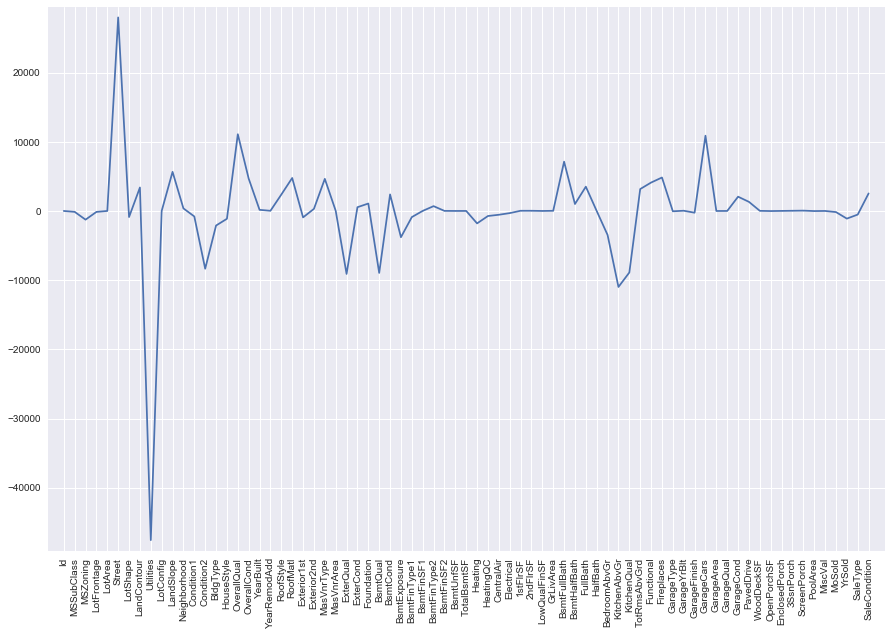

In [50]:
lasso = Lasso(alpha=0.4, normalize=True)
lasso_coef = lasso.fit(train_l, y).coef_
print(lasso_coef)

# Plotting the coefficients
fig, ax = plt.subplots(figsize = (15, 10))
_ = plt.plot(range(len(names)), lasso_coef)
_ = plt.xticks(range(len(names)), names.values, rotation=90)
_ = plt.margins(0.02)
_ = plt.show()

## _XG Boost_

In [51]:
XGB_model = XGBClassifier()
XGB_model.fit(X_train, y_train)
XGB_pred = XGB_model.predict(X_test)
print(mean_absolute_error(y_test, XGB_pred))

28416.76712328767


C:\Users\Carmijh0\Anoconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [52]:
accuracy_score(y_test, XGB_pred)

0.00684931506849315

## _Submission_

In [53]:
# my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': y_pred})
# my_submission.to_csv('NSS_ScreamingTurtle.csv', index=False)

#### _1st submission came out to 0.17010 score (5/15/2018) using a Random Forest Regressor_